스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 132ms/step
스텝 5100에서 판별자 손실: 0.7242973446846008
스텝 5100에서 적대적 손실: 0.9074257016181946
1/1 [==============================] - 0s 118ms/step
스텝 5200에서 판별자 손실: 0.7353428602218628
스텝 5200에서 적대적 손실: 0.8588690757751465
1/1 [==============================] - 0s 121ms/step
스텝 5300에서 판별자 손실: 0.7042077779769897
스텝 5300에서 적대적 손실: 0.8131497502326965
1/1 [==============================] - 0s 110ms/step
스텝 5400에서 판별자 손실: 0.6836520433425903
스텝 5400에서 적대적 손실: 0.7892815470695496
1/1 [==============================] - 0s 124ms/step
스텝 5500에서 판별자 손실: 0.6909801959991455
스텝 5500에서 적대적 손실: 0.8066731691360474
1/1 [==============================] - 0s 120ms/step
스텝 5600에서 판별자 손실: 0.6983469724655151
스텝 5600에서 적대적 손실: 0.8142397999763489
1/1 [==============================] - 0s 131ms/step
스텝 5700에서 판별자 손실: 0.7004221677780151
스텝 5700에서 적대적 손실: 0.7464509606361389
1/1 [==============================] - 0s 132ms/step
스텝 5800에서 판별자 손실: 0.86

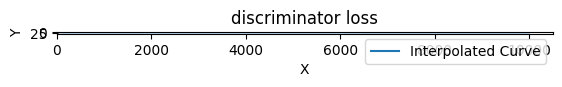

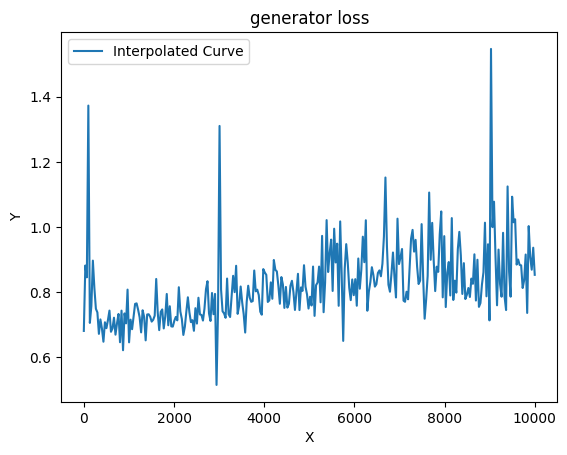

In [2]:
import keras
from keras import layers
import numpy as np
import tensorflow as tf
from scipy.interpolate import interp1d

latent_dim = 32
height = 32
width = 32   # 32x32 픽셀
channels =3 # rgb

"""생성자는 32부터 출발함 generator_input 계속 인풋으로 쓰임 (32,)로 스타트"""
generator_input = keras.Input(shape = (latent_dim,))


# 입력을 16 × 16 크기의 128개 채널을 가진 특성 맵으로 변환합니다
"""16*16*128은 32,768로 32*32*3 = 3072보다 훨씬 크지만 우선 충분히 크게 만들고 나서 줄이려는듯??"""

x= layers.Dense(128*16*16)(generator_input) #완전연결로 쫙 일단 펴주는듯
x = layers.LeakyReLU()(x)
x = layers.Reshape((16,16,128))(x) #다시 x를 [16,16,128]로 업데이트


# 합성곱 층을 추가합니다 [16x16x256] 유지됨
x = layers.Conv2D(256,5,padding = 'same')(x)
x = layers.LeakyReLU()(x)


# 32 × 32 크기로 업샘플링합니다(전치 conv2d이용하면 늘어나나)
x = layers.Conv2DTranspose(256, 4, strides = 2, padding = 'same')(x)
#strides 2면 2칸씩 이동 이었던듯
x = layers.LeakyReLU()(x)

# 합성곱 층을 더 추가합니다
x = layers.Conv2D(256, 5, padding='same')(x) #5윈도우 이동시 4개빠지니 same pad.
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

#32x32 크기의 1개 채널을 가진 특성맵 생성(책서 3개 오탄가??)
x = layers.Conv2D(channels,7,activation = 'tanh',padding = 'same')(x)
##generator_input(32,) 부터 x 쫘라락해서 (32,32,3)까지
generator = keras.models.Model(generator_input, x)
generator.summary()

discriminator_input = layers.Input(shape=(height, width, channels))
x= layers.Conv2D(128,3)(discriminator_input) #128채널,(3,3)
x= layers.LeakyReLU()(x)
x = layers.Conv2D(128,4,strides=2)(x) #maxpooling대신에 strides로 반 정도 줄임
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)  #컨브넷 4개 거치면 2x2x128 (=512) 됨
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)  # 다 펴주니까 512개 됨

# 드롭아웃 층을 넣는 것이 아주 중요합니다!(노이즈 생성에서 멈추지 않도록)
x = layers.Dropout(0.4)(x)

# 분류 층
x = layers.Dense(1, activation='sigmoid')(x)


func1 =[]
func2= []
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# 옵티마이저에서 (값을 지정하여) 그래디언트 클리핑을 사용합니다
# 그래디언트 클리핑: 기울기 폭주 방지 임계값서 자르는 것인듯..
# 안정된 훈련을 위해서 학습률 감쇠를 사용합니다(디폴트 0.001인가 그랬었지)
discriminator_optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0008, clipvalue=1.0, decay=1e-8)


discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')



discriminator.trainable = True #판별자 가중치 학습 못하게

gan_input = keras.Input(shape=(latent_dim,)) #(32,)부터
gan_output = discriminator(generator(gan_input)) # Gan_func()= 판별자(생성자)
gan = keras.models.Model(gan_input,gan_output)

##기울기크리핑과 학습율 엄청낮춘 것
gan_optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

import os
from keras.preprocessing import image
import matplotlib.pyplot as plt

# CIFAR10 데이터를 로드합니다
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 개구리 이미지를 선택합니다(클래스 6)
x_train = x_train[y_train.flatten()==6]

print(x_train.shape) #개구리 5천마리 x 32x32x3 pixel
plt.imshow(x_train[0])

x_train = x_train.reshape( # """ 5000마리는 두고 나머지는 x/255. """
   (x_train.shape[0],)+(height,width,channels)).astype('float32') / 255.

from google.colab import drive
drive.mount('/content/drive')

iterations = 10000
batch_size = 20
save_dir = '/content/drive/MyDrive/datasets/gan_images/' #코랩시에는 경로 변경 必

with tf.device('/device:GPU:0'):
  start = 0
  from google.colab import drive
  drive.mount('/content/drive')
  save_dir = '/content/drive/MyDrive/gan_images/'
  import os
  if not os.path.exists(save_dir):
      os.makedirs(save_dir)
  for step in range(iterations):
      # 잠재 공간에서 무작위로 포인트를 샘플링합니다(정규분포로!!위에 설명중에 有)
      # (batch[20] X latent_dim[32]):위에서 계속 생성자는 latent_dim[32]부터 출발했음
      random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

      # 가짜 이미지를 디코딩합니다
      generated_images = generator.predict(random_latent_vectors)

      # 진짜 이미지와 연결합니다(진짜이미지는 걍 순차적으로: 개수는 똑같이 함(배치 만큼))
      stop = start + batch_size  #start에서 배치만큼 계속 더해감(뒤에서)
      real_images = x_train[start: stop]
      combined_images = np.concatenate([generated_images, real_images])

      # 진짜와 가짜 이미지를 구분하여 레이블을 합칩니다
      # [32 x 1]차원 하나는 1행렬 하나는 0행렬  ==> [64X1] 행렬 됨
      # """왜 위가 1행렬이지..? 위가 생성자 이미지 인데? """
      # """ ans > 진짜가 0으로 해논듯 여긴..."""
      labels = np.concatenate([np.ones((batch_size, 1)),
                              np.zeros((batch_size, 1))])

      # """레이블에 랜덤 노이즈를 추가합니다. 아주 중요합니다!"""
      # (위 모델 견고 방법중..(동적평형이니까 갇힐가능성 큼 !위험))
      #sol1. 판별자 드랍아웃 + sol2. 판별자 레이블에 랜덤노이즈
      # """전부에 0.05*(0~1랜덤 소수) 약 0.025씩 더해줘서 노이즈 생성 """
      labels += 0.05 * np.random.random(labels.shape)

      # discriminator를 훈련합니다(gan과 별개로 인듯)
      d_loss = discriminator.train_on_batch(combined_images, labels)

      #"""gan으로 생성자 훈련부분 : 생성자는 모두 진짜가 되게끔 하는게 목적"""
      #"""정답을 모두 0[여기서 정답]으로"""
      # 잠재 공간에서 무작위로 포인트를 샘플링합니다
      random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

      # """모두 '진짜 이미지'라고 레이블을 만듭니다"""
      misleading_targets = np.zeros((batch_size, 1))

      # 생성자(generator)를 훈련합니다(gan 모델에서 discriminator의 가중치는 동결됩니다)
      a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

      start += batch_size
      if start > len(x_train) - batch_size: #위로 넘어가기전에 다시 0으로(진짜이미지)
        start = 0
      func1.append([step, d_loss])
      func2.append([step, a_loss])

      # 중간 중간 저장하고 그래프를 그립니다
      if step % 100 == 0:
          # 모델 가중치를 저장합니다
          gan.save_weights('/content/drive/MyDrive/ts.h5')



          # 측정 지표를 출력합니다
          print('스텝 %s에서 판별자 손실: %s' % (step, d_loss))
          print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))

          # 생성된 이미지 하나를 저장합니다
          img = image.array_to_img(generated_images[0] * 255., scale=False)
          img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

          # 비교를 위해 진짜 이미지 하나를 저장합니다
          img = image.array_to_img(real_images[0] * 255., scale=False)
          img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

def function(t , f):
  points = np.array(t)
  x = points[:, 0]
  y = points[:, 1]

  # 곡선 보간
  x_new = np.linspace(x.min(), x.max(), 300)  # 곡선의 매끄러움을 위한 더 많은 x 좌표 생성
  spline = interp1d(x, y, kind='cubic')       # cubic은 부드러운 곡선을 위한 옵션
  y_smooth = spline(x_new)

  # 그래프 그리기 # 원래 데이터 포인트
  plt.plot(x_new, y_smooth, '-', label='Interpolated Curve')  # 보간된 곡선
  plt.legend()
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title(f)
  plt.show()

function(func1,'discriminator loss')
function(func2, 'generator loss')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


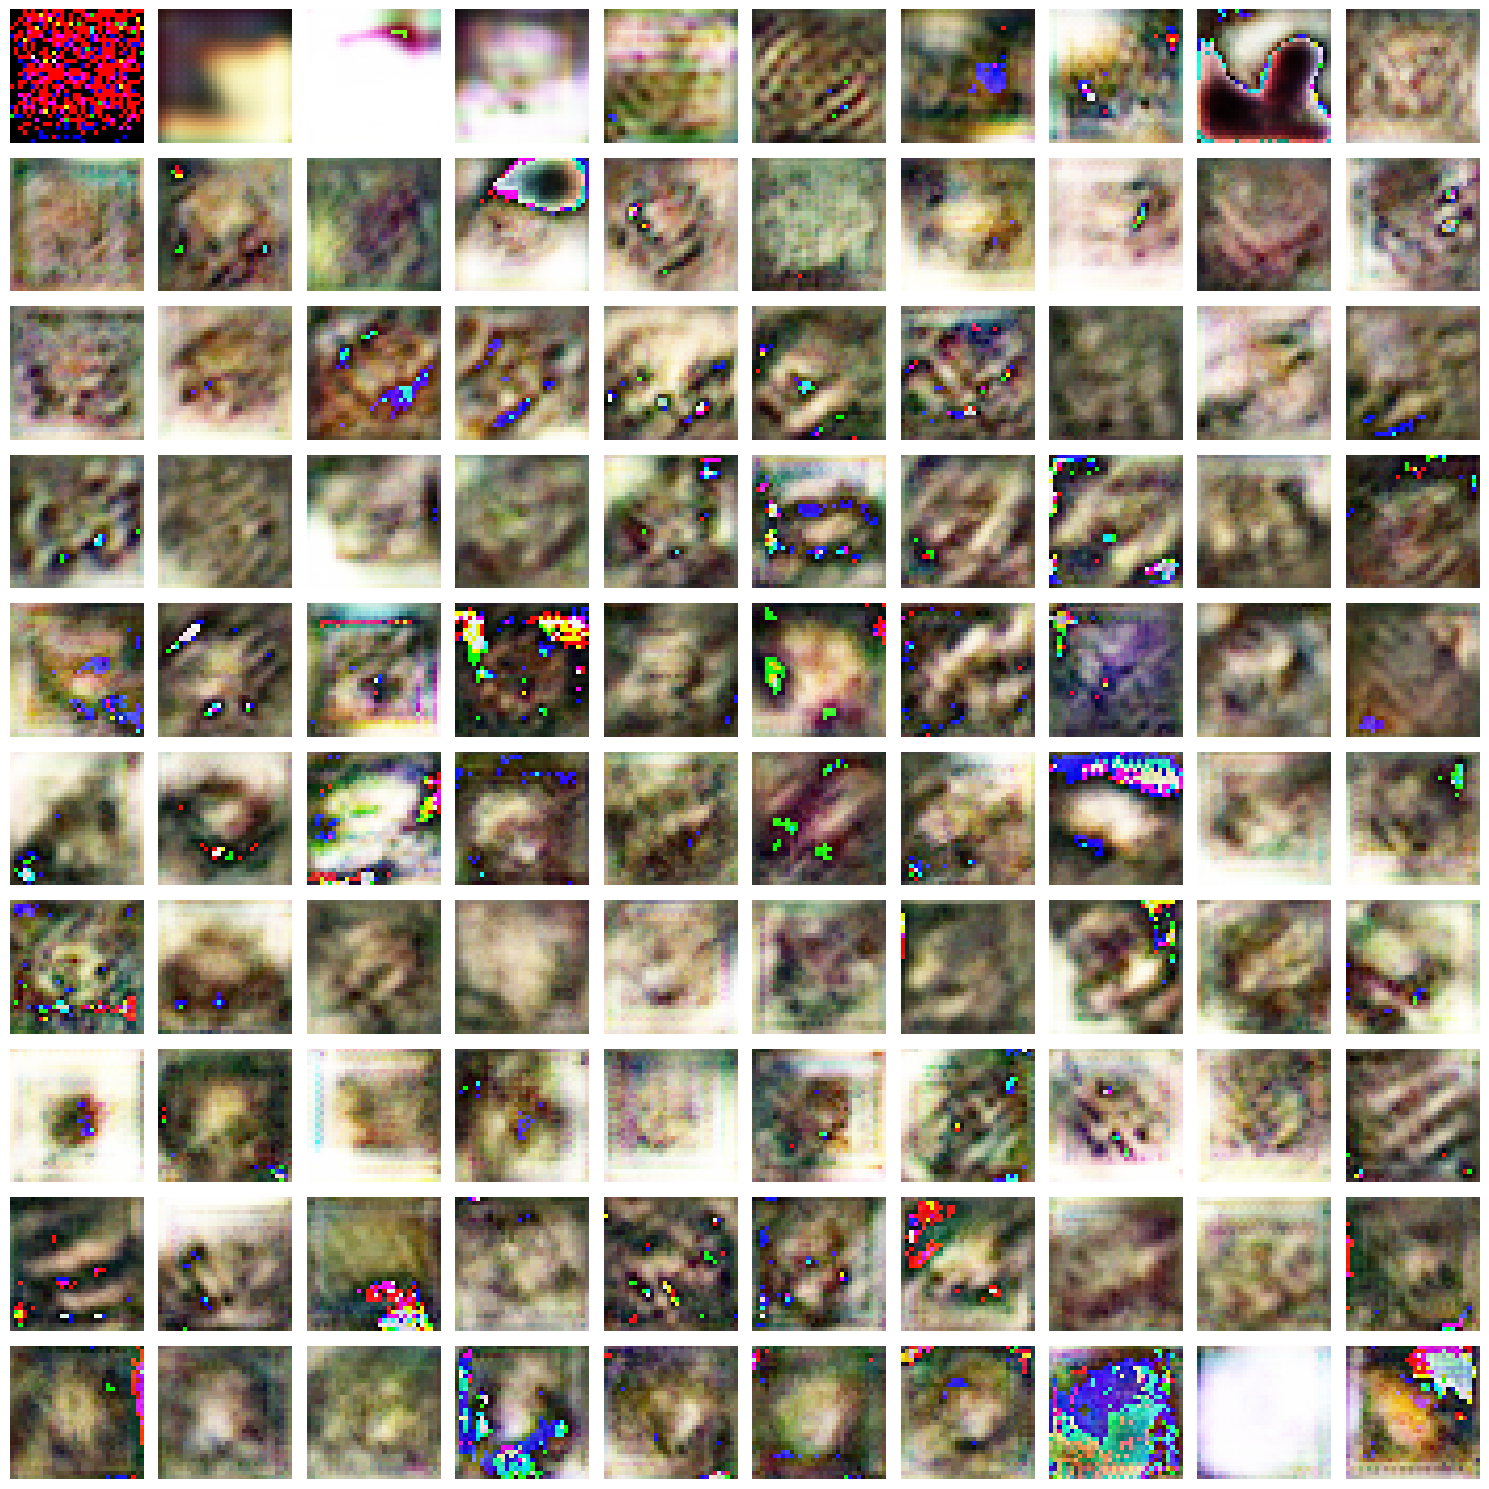

In [10]:
from google.colab import drive
drive.mount('/content/drive')

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 이미지 파일이 있는 폴더 경로 지정
folder_path = '/content/drive/MyDrive/gan_images/'

# 10x10 그리드의 이미지를 나타내기 위해서 그림 크기를 설정
if not os.path.exists(folder_path):
    print("폴더 경로가 존재하지 않습니다.")
else:
    # 이미지 파일이 제대로 있는지 확인
    file_check = [os.path.exists(os.path.join(folder_path, f"generated_frog{i*100}.png")) for i in range(100)]
    if not all(file_check):
        missing_files = [f"generated_frog{i*100}.png" for i, exists in enumerate(file_check) if not exists]
        print(f"다음 파일들이 누락되었습니다: {missing_files}")
    else:
        # 10x10 그리드에 이미지를 나타내기 위한 그림 크기 설정
        fig, axes = plt.subplots(10, 10, figsize=(15, 15))

        # 이미지 로드 및 그리드에 배치
        for i, ax in enumerate(axes.flat):
            file_path = os.path.join(folder_path, f"generated_frog{i*100}.png")
            img = mpimg.imread(file_path)  # 이미지 읽기
            ax.imshow(img)  # 이미지 표시
            ax.axis('off')  # 축 숨기기

        plt.tight_layout()
        plt.show()

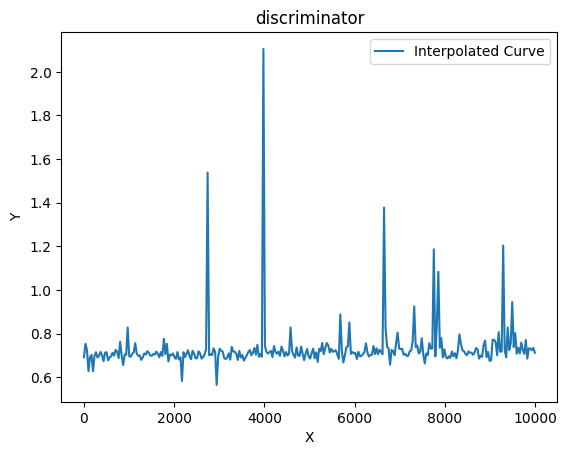

In [3]:
function(func1, 'discriminator')